## Load essential libraries

In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from collections import Counter
import string
from numpy import dot
from numpy.linalg import norm

### Path for clean and obfuscated files

In [515]:
# change the path according to your own directory
clean = "clean/"
obfuscated = "obfuscated/"


In [35]:
from os import listdir
from os.path import isfile, join
cleanfiles = ['c'+f for f in listdir(clean) if isfile(join(clean, f))]
obfuscatedfiles = ['o'+f for f in listdir(obfuscated) if isfile(join(obfuscated, f))]

In [36]:
print("Total clean files", len(cleanfiles))
print("Total obfuscated files", len(obfuscatedfiles))

Total clean files 1081
Total obfuscated files 472


The data is skewed towards clean files.
Three ways to counter this problem
* Undersample clean files
* Oversample obfuscated files
* Generate more obfuscated files from the clean files

### Sample clean file

In [38]:
with open(clean + cleanfiles[0][1:], "rb") as f:
    print(f.read().decode('utf-16'))

Function Setup-Profile{
    
    $hasProfile = Test-Path -Path $profile

    if ($hasProfile -eq $false){
        $answer = Read-Host "No profile detected. Would you like to create one? (Y)es or (N)o"
        while("y","n","yes","no" -notcontains $answer)
        {
        	$answer = Read-Host "Yes or No"
        }
        
            if ($answer -eq "y"){
                New-Item -Path $profile -ItemType "file" -Force
            } 
    }
}




### Sample obfuscated file

In [39]:
with open(obfuscated + obfuscatedfiles[0][1:], "rb") as f:
    print(f.read().decode('utf-16'))


function Get-UserCertificate {

[CmdletBinding()]
Param()
   Write-Debug "PrivateData: $($ExecutionContext.SessionState.Module | fl * | Out-String)"
   $UserCertificate = Get-AuthenticodeCertificate $ExecutionContext.SessionState.Module.PrivateData
   $ExecutionContext.SessionState.Module.PrivateData = $UserCertificate.Thumbprint
   return $UserCertificate
}

function Get-AuthenticodeCertificate {
[CmdletBinding()]
PARAM (
   $Name = $ExecutionContext.SessionState.Module.PrivateData
)

BEGIN { 
   if(!$ExecutionContext.SessionState.Module.PrivateData -and $Name) {
      $ExecutionContext.SessionState.Module.PrivateData = $Name
   }
}

PROCESS {
   trap {
      Write-Host "The authenticode script module requires configuration to function fully!"
      Write-Host
      Write-Host "You must put the path to your default signing certificate in the module metadata"`
                 "file before you can use the module's Set-Authenticode cmdlet or to the 'mine'"`
                 "feature of

In [72]:
df = pd.DataFrame(cleanfiles+obfuscatedfiles, columns=['fileName'])
df

,fileName
0,c5158.ps1
1,c866.ps1
2,c4534.ps1
3,c6323.ps1
4,c696.ps1
...,...
1548,o506.ps1
1549,o6064.ps1
1550,o4713.ps1
1551,o1125.ps1


Function to generate the label and convert the byte file into string

In [80]:
def getContentAndLabel(filename):
    label, name = filename[0], filename.split('.')[0]
    if label == 'c':
        with open(clean + filename[1:], "rb") as f:
            # type string
            temp = f.read().decode('utf-16')
            return pd.Series([name, temp, 0])
    else:
        with open(obfuscated + filename[1:], "rb") as f:
            # type string
            temp = f.read().decode('utf-16')
            return pd.Series([name, temp, 1])

In [81]:
getContentAndLabel(cleanfiles[0])

0                                                c5158
1    Function Setup-Profile{\r\n    \r\n    $hasPro...
2                                                    0
dtype: object

DataFrame df stores the filename, content and label for further analysis

In [82]:
df[['fileName', 'content', 'label']] = df['fileName'].apply(getContentAndLabel)
df

,fileName,content,label
0,c5158,Function Setup-Profile{\r\n \r\n $hasPro...,0
1,c866,function Get-FridaysThirteenth {\r\n\tparam (\...,0
2,c4534,Set-Alias sudo Invoke-RunAs\r\n\r\nfunction In...,0
3,c6323,function Show-AsciiFace{\r\n param(...,0
4,c696,"function elevate-process\r\n{\r\n\t$file, [str...",0
...,...,...,...
1548,o506,public partial class MailboxTasks : System.Web...,1
1549,o6064,& ( ${ENV:p`UBL`ic}[13]+${e`NV:PUB`l`iC}[5]+'...,1
1550,o4713,"[stRiNG]::jOIN('' ,([ReGEx]::maTCHES( "")''nIo...",1
1551,o1125,"$iXWr= [CHaR[ ] ]"")''NiOJ-'x'+]3,1[)(GNIrTsoT....",1


In [83]:
df2 = df.sample(10)
df2

,fileName,content,label
1373,o2688,$test=(&('get-'+'fol'+'der') testing|.('ge'+'t...,1
587,c4615,\r\nif ((get-pssnapin |% {$_.name}) -notcontai...,0
748,c6166,\r\nFunction Replace-ExtraLines\r\n{\r\n Pa...,0
288,c4437,@set @script=0 \r\n\r\nwith (WScript.Arguments...,0
1131,o3936,Function Get-DiskSizeInfo {\r\n \r\n\r\...,1
1452,o2951,function Get-TheVillageChurchPodCast {\r\n\r\n...,1
427,c2530,"param($sqlserver, $filepath)\r\n\r\n\r\nimport...",0
161,c3314,function Write-Host\r\n{\r\n \r\n\r\n pa...,0
692,c3196,function Debug-Regex {\r\n\r\n param ([Param...,0
45,c1049,"ew-CodeSigningCert.ps1 $pwd\Certs ""Joel Bennet...",0


It can be observed from the data that obfuscated files have more character like in [{, }, `, (, ), $, @]
and clean files have normal alphanumberic characters
Therefore:
* A vector for all possible 100 characters was created
* For each file the count of number of characters are generated
* Total number of character count is also stored for normalization

In [110]:
chars = [c for c in string.printable]
def characterCount(string):
    # charater count
    c = Counter(string)
    # charater vector
    vector = [c.get(char, 0) for char in chars]
    # print(vector)
    return pd.Series([vector, sum(vector)])

In [107]:
characterCount(df.iloc[0]['content'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 5, 5, 34, 10, 0, 6, 13, 0, 1, 11, 2, 12, 22, 5, 2, 14, 14, 16, 4, 0, 6, 0, 5, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 4, 0, 6, 0, 2, 1, 2, 0, 0, 1, 0, 2, 0, 0, 16, 0, 9, 0, 0, 0, 5, 5, 0, 0, 3, 12, 1, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 142, 1, 17, 17, 0, 0]


0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 5, 5, 34...
1                                                  465
dtype: object

In [111]:
df2[['characterVector', 'totalCharacter']] = df2['content'].apply(characterCount)
df2

,fileName,content,label,characterVector,totalCharacter
1373,o2688,$test=(&('get-'+'fol'+'der') testing|.('ge'+'t...,1,"[1, 3, 2, 1, 0, 0, 0, 0, 0, 0, 21, 1, 16, 15, ...",598
587,c4615,\r\nif ((get-pssnapin |% {$_.name}) -notcontai...,0,"[4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 32, 6, 11, 5, 5...",551
748,c6166,\r\nFunction Replace-ExtraLines\r\n{\r\n Pa...,0,"[32, 18, 30, 11, 0, 2, 2, 0, 2, 2, 1253, 301, ...",58602
288,c4437,@set @script=0 \r\n\r\nwith (WScript.Arguments...,0,"[6, 6, 2, 1, 0, 0, 0, 0, 0, 0, 14, 7, 16, 13, ...",810
1131,o3936,Function Get-DiskSizeInfo {\r\n \r\n\r\...,1,"[11, 11, 10, 3, 0, 0, 0, 0, 0, 0, 35, 11, 23, ...",1718
1452,o2951,function Get-TheVillageChurchPodCast {\r\n\r\n...,1,"[14, 9, 3, 2, 0, 0, 0, 0, 2, 0, 185, 23, 59, 6...",4293
427,c2530,"param($sqlserver, $filepath)\r\n\r\n\r\nimport...",0,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 6, 16, 14, ...",935
161,c3314,function Write-Host\r\n{\r\n \r\n\r\n pa...,0,"[2, 13, 19, 19, 4, 2, 0, 0, 0, 0, 85, 17, 52, ...",4375
692,c3196,function Debug-Regex {\r\n\r\n param ([Param...,0,"[1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 28, 17, 16, 9, ...",1205
45,c1049,"ew-CodeSigningCert.ps1 $pwd\Certs ""Joel Bennet...",0,"[13, 11, 9, 10, 8, 15, 10, 1, 4, 10, 393, 27, ...",8931


In [112]:
df[['characterVector', 'totalCharacter']] = df['content'].apply(characterCount)
df

,fileName,content,label,characterVector,totalCharacter
0,c5158,Function Setup-Profile{\r\n \r\n $hasPro...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 5, 5, 34...",465
1,c866,function Get-FridaysThirteenth {\r\n\tparam (\...,0,"[6, 5, 4, 2, 0, 0, 0, 0, 0, 1, 7, 2, 1, 8, 14,...",241
2,c4534,Set-Alias sudo Invoke-RunAs\r\n\r\nfunction In...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 1, 18, 14, ...",959
3,c6323,function Show-AsciiFace{\r\n param(...,0,"[211, 15, 109, 22, 6, 50, 12, 3, 17, 20, 32, 3...",2594
4,c696,"function elevate-process\r\n{\r\n\t$file, [str...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 2, 10, 1, 2...",308
...,...,...,...,...,...
1548,o506,public partial class MailboxTasks : System.Web...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 20, 11, 30,...",844
1549,o6064,& ( ${ENV:p`UBL`ic}[13]+${e`NV:PUB`l`iC}[5]+'...,1,"[5, 8, 7, 4, 3, 4, 1, 8, 0, 2, 27, 4, 21, 8, 7...",1814
1550,o4713,"[stRiNG]::jOIN('' ,([ReGEx]::maTCHES( "")''nIo...",1,"[134, 18, 5, 8, 5, 2, 2, 3, 2, 2, 127, 4, 147,...",5589
1551,o1125,"$iXWr= [CHaR[ ] ]"")''NiOJ-'x'+]3,1[)(GNIrTsoT....",1,"[275, 6, 12, 7, 4, 2, 4, 5, 0, 2, 16, 3, 32, 1...",2024


In [115]:
df_clean = df[df['label'] == 0]
df_clean

,fileName,content,label,characterVector,totalCharacter
0,c5158,Function Setup-Profile{\r\n \r\n $hasPro...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 5, 5, 34...",465
1,c866,function Get-FridaysThirteenth {\r\n\tparam (\...,0,"[6, 5, 4, 2, 0, 0, 0, 0, 0, 1, 7, 2, 1, 8, 14,...",241
2,c4534,Set-Alias sudo Invoke-RunAs\r\n\r\nfunction In...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 1, 18, 14, ...",959
3,c6323,function Show-AsciiFace{\r\n param(...,0,"[211, 15, 109, 22, 6, 50, 12, 3, 17, 20, 32, 3...",2594
4,c696,"function elevate-process\r\n{\r\n\t$file, [str...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 2, 10, 1, 2...",308
...,...,...,...,...,...
1076,c1482,"PARAM ( \r\n [Parameter(Position=1, Mandator...",0,"[58, 61, 46, 50, 17, 25, 17, 13, 11, 11, 22, 0...",1648
1077,c3295,"try {add-type -AssemblyName ""Microsoft.SqlServ...",0,"[21, 7, 3, 3, 4, 3, 3, 1, 9, 4, 193, 51, 68, 3...",3392
1078,c6474,Clear-Host\r\n$Location = $($Env:PSModulePath)...,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 5, 8, 27,...",334
1079,c5141,function Catch-LongNames\r\n\r\n{\r\n\t[Cmdlet...,0,"[3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 43, 6, 32, 21, ...",1364


Considering all the clean files as truth, the average vector of those files will represent the clean file character
distribution. Cosine similarity is then used to get how similar two vectors are. If cosine similarity is close to 1
then the new vector is close to vector of clean file and can be labelled as clean. As cosine similarity is between
0 and 1. A threshold can be chosen to between 0 and 1.
Steps:
* Get average cosine vector for all clean files
* Use on the train data
* Find cosine similarity of each file with this average vector
* Plot and look for threshold and errors

In [131]:
AvgOfAllChars = None
def averageCharacters(df):
    total = df.shape[0]
    return np.sum(np.array(df['characterVector'].to_list()), axis = 0)/total

In [132]:
AvgOfAllChars = averageCharacters(df_clean)

In [134]:
def cosineSimilarity(vector):
    cos_sim = dot(vector, AvgOfAllChars)/(norm(vector)*norm(AvgOfAllChars))
    return cos_sim

In [135]:
df2['cosineSim'] = df2['characterVector'].apply(cosineSimilarity)
df2

,fileName,content,label,characterVector,totalCharacter,cosineSim
1373,o2688,$test=(&('get-'+'fol'+'der') testing|.('ge'+'t...,1,"[1, 3, 2, 1, 0, 0, 0, 0, 0, 0, 21, 1, 16, 15, ...",598,0.646455
587,c4615,\r\nif ((get-pssnapin |% {$_.name}) -notcontai...,0,"[4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 32, 6, 11, 5, 5...",551,0.780964
748,c6166,\r\nFunction Replace-ExtraLines\r\n{\r\n Pa...,0,"[32, 18, 30, 11, 0, 2, 2, 0, 2, 2, 1253, 301, ...",58602,0.938732
288,c4437,@set @script=0 \r\n\r\nwith (WScript.Arguments...,0,"[6, 6, 2, 1, 0, 0, 0, 0, 0, 0, 14, 7, 16, 13, ...",810,0.956516
1131,o3936,Function Get-DiskSizeInfo {\r\n \r\n\r\...,1,"[11, 11, 10, 3, 0, 0, 0, 0, 0, 0, 35, 11, 23, ...",1718,0.863134
1452,o2951,function Get-TheVillageChurchPodCast {\r\n\r\n...,1,"[14, 9, 3, 2, 0, 0, 0, 0, 2, 0, 185, 23, 59, 6...",4293,0.742545
427,c2530,"param($sqlserver, $filepath)\r\n\r\n\r\nimport...",0,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 53, 6, 16, 14, ...",935,0.838355
161,c3314,function Write-Host\r\n{\r\n \r\n\r\n pa...,0,"[2, 13, 19, 19, 4, 2, 0, 0, 0, 0, 85, 17, 52, ...",4375,0.939072
692,c3196,function Debug-Regex {\r\n\r\n param ([Param...,0,"[1, 2, 0, 0, 0, 0, 0, 0, 0, 1, 28, 17, 16, 9, ...",1205,0.970637
45,c1049,"ew-CodeSigningCert.ps1 $pwd\Certs ""Joel Bennet...",0,"[13, 11, 9, 10, 8, 15, 10, 1, 4, 10, 393, 27, ...",8931,0.950699


In [136]:
df['cosineSim'] = df['characterVector'].apply(cosineSimilarity)
df

,fileName,content,label,characterVector,totalCharacter,cosineSim
0,c5158,Function Setup-Profile{\r\n \r\n $hasPro...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 0, 5, 5, 34...",465,0.969682
1,c866,function Get-FridaysThirteenth {\r\n\tparam (\...,0,"[6, 5, 4, 2, 0, 0, 0, 0, 0, 1, 7, 2, 1, 8, 14,...",241,0.844702
2,c4534,Set-Alias sudo Invoke-RunAs\r\n\r\nfunction In...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 1, 18, 14, ...",959,0.932405
3,c6323,function Show-AsciiFace{\r\n param(...,0,"[211, 15, 109, 22, 6, 50, 12, 3, 17, 20, 32, 3...",2594,0.834526
4,c696,"function elevate-process\r\n{\r\n\t$file, [str...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13, 2, 10, 1, 2...",308,0.713786
...,...,...,...,...,...,...
1548,o506,public partial class MailboxTasks : System.Web...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 37, 20, 11, 30,...",844,0.961149
1549,o6064,& ( ${ENV:p`UBL`ic}[13]+${e`NV:PUB`l`iC}[5]+'...,1,"[5, 8, 7, 4, 3, 4, 1, 8, 0, 2, 27, 4, 21, 8, 7...",1814,0.380781
1550,o4713,"[stRiNG]::jOIN('' ,([ReGEx]::maTCHES( "")''nIo...",1,"[134, 18, 5, 8, 5, 2, 2, 3, 2, 2, 127, 4, 147,...",5589,0.748462
1551,o1125,"$iXWr= [CHaR[ ] ]"")''NiOJ-'x'+]3,1[)(GNIrTsoT....",1,"[275, 6, 12, 7, 4, 2, 4, 5, 0, 2, 16, 3, 32, 1...",2024,0.274400


In [517]:
df.describe()

,label,totalCharacter,cosineSim
count,1553.000000,1553.000000,1553.000000
mean,0.303928,3912.975531,0.856954
std,0.460100,6805.611201,0.155978
min,0.000000,4.000000,0.137799
25%,0.000000,866.000000,0.802883
50%,0.000000,1798.000000,0.913948
75%,1.000000,3723.000000,0.966674
max,1.000000,58603.000000,0.995617


<AxesSubplot:xlabel='totalCharacter', ylabel='cosineSim'>

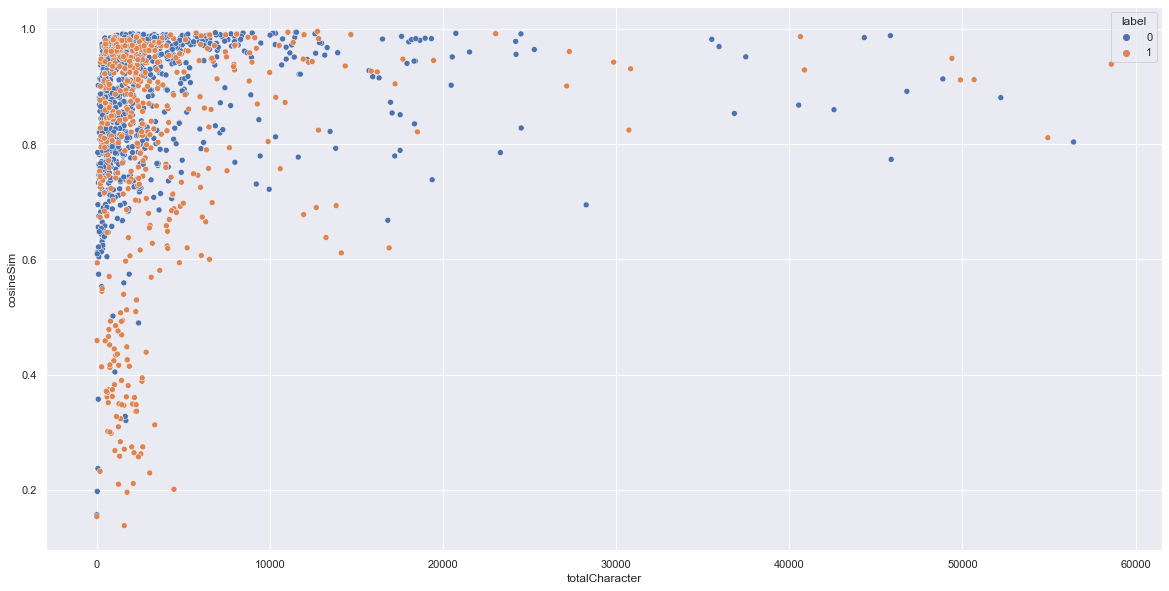

In [142]:
sns.set(rc={'figure.figsize':(20,10)})
sns.scatterplot(data=df, x="totalCharacter", y="cosineSim", hue="label")

Although it seems character count is good measure, it is possible for obfuscated files to have character count as clean files by having large alphanumeric variable names that does not make sense.
It is also important to have a good recall for obfuscated files. As it is important to detect most of the obfuscated files. It is okay if some of the clean code is detected as obfuscated but not vice-versa

In [143]:
df.corr()

,label,totalCharacter,cosineSim
label,1.000000,0.027788,-0.296895
totalCharacter,0.027788,1.000000,0.142689
cosineSim,-0.296895,0.142689,1.000000


In [170]:
df3 = pd.DataFrame(df.characterVector.tolist(), index= df.index)
df3

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,4,0,4,0,142,1,17,17,0,0
1,6,5,4,2,0,0,0,0,0,1,...,4,0,4,0,27,15,10,10,0,0
2,0,0,0,0,0,0,0,0,0,0,...,2,0,2,0,129,0,36,36,0,0
3,211,15,109,22,6,50,12,3,17,20,...,36,2,36,0,501,0,41,41,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,16,6,12,12,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0,0,0,0,0,0,0,0,0,0,...,5,0,5,0,157,0,20,21,0,0
1549,5,8,7,4,3,4,1,8,0,2,...,7,0,7,0,156,0,24,24,0,0
1550,134,18,5,8,5,2,2,3,2,2,...,13,3,13,0,399,141,91,91,0,0
1551,275,6,12,7,4,2,4,5,0,2,...,3,3,3,0,95,1,10,10,0,0


In [516]:
df3.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,...,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.0,1553.0
mean,14.395364,14.016742,10.469414,8.664520,6.552479,6.085641,4.946555,4.988410,4.036703,4.118480,...,28.320670,5.974887,28.138442,0.110753,760.091436,43.310367,103.124276,103.303928,0.0,0.0
std,39.280672,37.890676,38.594432,42.455087,33.964733,31.521139,38.551182,35.388053,20.392965,20.712598,...,55.583991,26.014840,55.119898,1.662378,1738.359949,193.144267,180.326688,180.345839,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.0,0.0
25%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,0.000000,5.000000,0.000000,83.000000,0.000000,25.000000,25.000000,0.0,0.0
50%,4.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.000000,2.000000,11.000000,0.000000,240.000000,0.000000,47.000000,48.000000,0.0,0.0
75%,11.000000,11.000000,7.000000,5.000000,3.000000,3.000000,2.000000,1.000000,2.000000,2.000000,...,28.000000,4.000000,28.000000,0.000000,677.000000,17.000000,102.000000,102.000000,0.0,0.0
max,706.000000,632.000000,1134.000000,1048.000000,734.000000,877.000000,1415.000000,1034.000000,517.000000,541.000000,...,634.000000,460.000000,634.000000,60.000000,25925.000000,3826.000000,1910.000000,1911.000000,0.0,0.0


In [178]:
df3.isnull().sum()

0     0
1     0
2     0
3     0
4     0
     ..
95    0
96    0
97    0
98    0
99    0
Length: 100, dtype: int64

* Powershell cheatsheet - https://www.theochem.ru.nl/~pwormer/teachmat/PS_cheat_sheet.html

### Train test split

Import important libraries and functions

In [531]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

The overall set is partitioned in such a way that (80-20) ratio. Where 20% is the test sent and validation set is included in the train set. It is also to be noted that the train and test set contain the same proportion of distribution of labels. For this case stratify parameter is passed.

In [179]:
x = pd.concat([df[['totalCharacter', 'cosineSim']], df3], axis=1)
y = df['label']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, stratify=y)

A logistic regresssion is binary classifier that tries to find the weight of each feature in the input.
This classifier seems good for this task. However, other classifier such as random forest etc can also be used.

In [182]:
pipe = Pipeline([('pca', PCA(n_components=20)), ('classifier' , LogisticRegression())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

best_clf = clf.fit(xTrain, yTrain)

yPred = best_clf.predict(xTest)

print(classification_report(yTest, yPred))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       216
           1       0.86      0.62      0.72        95

    accuracy                           0.85       311
   macro avg       0.85      0.79      0.81       311
weighted avg       0.85      0.85      0.84       311



/Users/shikharagrawal/opt/miniconda3/envs/acalvio/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Error Analysis:
1 for Obfuscated and 0 for Clean.
We could see that recall for obfuscated files is not good.

In [193]:
best_clf.best_estimator_._final_estimator.coef_

array([[ 3.51563657e-04,  0.00000000e+00, -2.51615811e-02,
         7.41213184e-03,  2.75893338e-03,  3.28654244e-02,
        -2.33271613e-03,  2.98732626e-02,  0.00000000e+00,
         8.07038937e-03,  0.00000000e+00,  1.94075569e-02,
         1.85188219e-03,  3.09512415e-03, -5.29772747e-03,
         7.35984047e-03, -1.85633265e-03,  1.25405816e-03,
         1.67386403e-03,  3.37397258e-03, -3.98763013e-03,
        -1.18760143e-02, -7.99177687e-03,  3.05119604e-05,
         8.34205450e-04, -4.45808083e-03, -6.88317353e-04,
        -3.42365025e-03,  0.00000000e+00, -1.36816160e-03,
        -6.21212592e-04,  9.96021795e-04, -9.71025917e-04,
         3.36315874e-03, -6.31246085e-03,  0.00000000e+00,
         0.00000000e+00,  3.57775943e-03, -9.28662601e-03,
        -2.24445705e-03,  5.43954207e-03,  5.54780918e-03,
         5.08307102e-03, -2.05481772e-02, -2.16923767e-02,
         0.00000000e+00, -2.43119006e-03,  0.00000000e+00,
        -2.11568867e-02,  0.00000000e+00,  0.00000000e+0

In [196]:
pipe = Pipeline([('pca', PCA(n_components=20)), ('classifier' , LogisticRegression())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

best_clf = clf.fit(xTrain, yTrain)

yPred = best_clf.predict(xTest)

print(classification_report(yTest, yPred))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
              precision    recall  f1-score   support

           0       0.81      0.98      0.89       216
           1       0.90      0.49      0.64        95

    accuracy                           0.83       311
   macro avg       0.86      0.74      0.76       311
weighted avg       0.84      0.83      0.81       311



In [197]:
best_clf.best_estimator_._final_estimator.coef_

array([[ 2.33074127e-05, -3.26344997e-04, -1.63557697e-04,
        -6.31946326e-03,  1.01154090e-02,  7.96880997e-03,
        -1.35489155e-02,  5.48212834e-03,  1.48569097e-03,
        -1.03754397e-02, -1.02925497e-02, -1.38721884e-03,
         8.63580226e-03, -1.52575926e-04, -1.70127660e-03,
        -6.85402289e-03,  2.10226529e-03,  9.49562960e-03,
        -6.64839615e-03,  9.06678097e-03]])

## Iteration 2 additional features

To generate additional features we need to carefully look at the code.
I found that feature like:
* Number of variables
* Number of assignment operators
* Number of invocation calls
* Number of command-names 
* Size of the array\
etc are good features to extract.

This features can be extracted by generating the Abstract Syntax Tree of the script.
There were some challenges in invoking the powershell script from jupyter notebooks in macOS.
So I wrote a separate script to get addional feature from Get-RvoFeatureVector command.
* Refer this for more details - https://github.com/danielbohannon/Revoke-Obfuscation
* My script can be found here - https://github.com/shikhar1996/Powershell_Obfuscation/tree/main/script

In [198]:
import ast

In [206]:
token = "Get-PSOne Token -Path $Path -TokenKind Variable -IncludeNestedToken | Select-Object -ExpandProperty Text | Sort-Object -Unique"

In [235]:
import subprocess

def run(cmd):
    '''
    process=subprocess.run(["pwsh",cmd],stdout=subprocess.PIPE);
    result=process.stdout
    print (result)
    return result
    '''
    proc = subprocess.Popen(['pwsh'] + [cmd], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    output, err = proc.communicate()
    print(output)
    #completed = subprocess.call(["pwsh", "-Command", cmd], capture_output=True)
    #print(completed.stdout)
    #return completed

In [237]:
run("Get-RvoFeatureVector '/Users/shikharagrawal/Downloads/task/clean/60.ps1'")

b'\nUsage: pwsh[.exe] [-Login] [[-File] <filePath> [args]]\n                  [-Command { - | <script-block> [-args <arg-array>]\n                                | <string> [<CommandParameters>] } ]\n                  [-ConfigurationName <string>] [-CustomPipeName <string>]\n                  [-EncodedCommand <Base64EncodedCommand>]\n                  [-ExecutionPolicy <ExecutionPolicy>] [-InputFormat {Text | XML}]\n                  [-Interactive] [-MTA] [-NoExit] [-NoLogo] [-NonInteractive] [-NoProfile]\n                  [-OutputFormat {Text | XML}] [-SettingsFile <filePath>] [-SSHServerMode] [-STA]\n                  [-Version] [-WindowStyle <style>] [-WorkingDirectory <directoryPath>]\n\n       pwsh[.exe] -h | -Help | -? | /?\n\nPowerShell Online Help https://aka.ms/powershell-docs\n\nAll parameters are case-insensitive.\n'


Load the additional features from the csv files

In [293]:
cleanAddon = pd.read_csv('clean.csv', header=None)
obfusAddon = pd.read_csv('obfuscated.csv', header=None)
header = pd.read_csv('cleanHeader.csv')

In [294]:
cleanAddon

,0,1,2,3,4,5,6,7,8,9,...,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1006.ps1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1018.ps1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1024.ps1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1027.ps1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1029.ps1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,974.ps1
1077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,976.ps1
1078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,983.ps1
1079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,984.ps1


In [295]:
cols = list(header.columns) + ['fileName']
print(len(cols))

4999


In [296]:
cleanAddon.columns = cols
obfusAddon.columns = cols
cleanAddon

,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,AstGroupedArrayElementRangeCounts_40-50_Percent,...,AstVariableNameMetrics_Length_Mode,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,fileName
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1006.ps1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1018.ps1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1024.ps1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1027.ps1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1029.ps1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,974.ps1
1077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,976.ps1
1078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,983.ps1
1079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,984.ps1


In [297]:
def renameFile(string, label):
    name = string.split('.')[0]
    if label == 0:
        newName = 'c'+name
    else:
        newName = 'o'+name
    return newName

In [298]:
cleanAddon['fileName'] = cleanAddon['fileName'].apply(lambda x : renameFile(x, 0))
cleanAddon

,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,AstGroupedArrayElementRangeCounts_40-50_Percent,...,AstVariableNameMetrics_Length_Mode,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,fileName
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1006
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1018
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1024
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1027
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c974
1077,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c976
1078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c983
1079,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c984


In [299]:
obfusAddon['fileName'] = obfusAddon['fileName'].apply(lambda x : renameFile(x, 1))
obfusAddon

,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,AstGroupedArrayElementRangeCounts_40-50_Percent,...,AstVariableNameMetrics_Length_Mode,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,fileName
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o1000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o1009
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o1014
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o1019
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o1031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o969
468,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o977
469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o978
470,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o983


In [300]:
completeDF = pd.concat([cleanAddon, obfusAddon], ignore_index=True)
completeDF

,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,AstGroupedArrayElementRangeCounts_40-50_Percent,...,AstVariableNameMetrics_Length_Mode,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range,fileName
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1006
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1018
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1024
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1027
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,c1029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o969
1549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o977
1550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o978
1551,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,o983


In [301]:
finalDF = pd.merge(df.loc[:, ['fileName', 'content', 'label']], completeDF, on='fileName')
finalDF

,fileName,content,label,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,...,AstVariableNameMetrics_Length_Minimum,AstVariableNameMetrics_Length_Mode,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range
0,c5158,Function Setup-Profile{\r\n \r\n $hasPro...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,c866,function Get-FridaysThirteenth {\r\n\tparam (\...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,c4534,Set-Alias sudo Invoke-RunAs\r\n\r\nfunction In...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,c6323,function Show-AsciiFace{\r\n param(...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,c696,"function elevate-process\r\n{\r\n\t$file, [str...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,o506,public partial class MailboxTasks : System.Web...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1549,o6064,& ( ${ENV:p`UBL`ic}[13]+${e`NV:PUB`l`iC}[5]+'...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1550,o4713,"[stRiNG]::jOIN('' ,([ReGEx]::maTCHES( "")''nIo...",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1551,o1125,"$iXWr= [CHaR[ ] ]"")''NiOJ-'x'+]3,1[)(GNIrTsoT....",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


FinalDF contains around 5000 features that can be used. The features not only include the ones I stated above
but also additional features on their statistics(like mean, median, length entropy)

## Additional Features Analysis

In [287]:
finalDF.corr()

,label,AstGroupedArrayElementRangeCounts_0-10_Count,AstGroupedArrayElementRangeCounts_0-10_Percent,AstGroupedArrayElementRangeCounts_10-20_Count,AstGroupedArrayElementRangeCounts_10-20_Percent,AstGroupedArrayElementRangeCounts_20-30_Count,AstGroupedArrayElementRangeCounts_20-30_Percent,AstGroupedArrayElementRangeCounts_30-40_Count,AstGroupedArrayElementRangeCounts_30-40_Percent,AstGroupedArrayElementRangeCounts_40-50_Count,...,AstVariableNameMetrics_Length_Minimum,AstVariableNameMetrics_Length_Mode,AstVariableNameMetrics_Length_Range,AstVariableNameMetrics_Length_Total,AstVariableNameMetrics_UpperAlphaPercent_Average,AstVariableNameMetrics_UpperAlphaPercent_Maximum,AstVariableNameMetrics_UpperAlphaPercent_Median,AstVariableNameMetrics_UpperAlphaPercent_Minimum,AstVariableNameMetrics_UpperAlphaPercent_Mode,AstVariableNameMetrics_UpperAlphaPercent_Range
label,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AstGroupedArrayElementRangeCounts_0-10_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AstGroupedArrayElementRangeCounts_0-10_Percent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AstGroupedArrayElementRangeCounts_10-20_Count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AstGroupedArrayElementRangeCounts_10-20_Percent,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AstVariableNameMetrics_UpperAlphaPercent_Maximum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AstVariableNameMetrics_UpperAlphaPercent_Median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AstVariableNameMetrics_UpperAlphaPercent_Minimum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AstVariableNameMetrics_UpperAlphaPercent_Mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [302]:
finalDF['label'].value_counts()

0    1081
1     472
Name: label, dtype: int64

Those features that have only 1 unique values in the entire columns are dropped as they do not have any effect.
This results in only around 140 features

In [303]:
# drop columsn where number of unique values are 1
nunique = finalDF.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
final_DF = finalDF.drop(cols_to_drop, axis=1)
# final_DF = finalDF.loc[:, (finalDF != 0).any(axis=0)]

In [304]:
final_DF

,fileName,content,label,AstCmdletMetrics_CharacterDistribution_._2e_Percent,AstCmdletMetrics_CharacterDistribution_/_2f_Percent,AstCmdletMetrics_CharacterDistribution_0_30_Count,AstCmdletMetrics_CharacterDistribution_0_30_Percent,AstCmdletMetrics_CharacterDistribution_1_31_Count,AstCmdletMetrics_CharacterDistribution_1_31_Percent,AstCmdletMetrics_CharacterDistribution_2_32_Count,...,LineByLineMetrics_Length_Maximum,LineByLineMetrics_Length_Median,LineByLineMetrics_Length_Minimum,LineByLineMetrics_Length_Mode,LineByLineMetrics_Length_Total,LineByLineMetrics_UpperAlphaPercent_Average,LineByLineMetrics_UpperAlphaPercent_Maximum,LineByLineMetrics_UpperAlphaPercent_Median,LineByLineMetrics_UpperAlphaPercent_Minimum,LineByLineMetrics_UpperAlphaPercent_Mode
0,c5158,Function Setup-Profile{\r\n \r\n $hasPro...,0,1.960784,11.764706,0,0.000000,2,3.921569,0,...,51,51,51,51,51,0.051282,0.051282,0.051282,0.051282,0.051282
1,c866,function Get-FridaysThirteenth {\r\n\tparam (\...,0,2.000000,12.000000,0,0.000000,1,2.000000,0,...,50,50,50,50,50,0.051282,0.051282,0.051282,0.051282,0.051282
2,c4534,Set-Alias sudo Invoke-RunAs\r\n\r\nfunction In...,0,1.960784,11.764706,0,0.000000,1,1.960784,0,...,51,51,51,51,51,0.051282,0.051282,0.051282,0.051282,0.051282
3,c6323,function Show-AsciiFace{\r\n param(...,0,1.960784,11.764706,0,0.000000,1,1.960784,1,...,51,51,51,51,51,0.051282,0.051282,0.051282,0.051282,0.051282
4,c696,"function elevate-process\r\n{\r\n\t$file, [str...",0,2.000000,12.000000,0,0.000000,1,2.000000,0,...,50,50,50,50,50,0.051282,0.051282,0.051282,0.051282,0.051282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548,o506,public partial class MailboxTasks : System.Web...,1,1.818182,10.909091,1,1.818182,1,1.818182,0,...,55,55,55,55,55,0.045455,0.045455,0.045455,0.045455,0.045455
1549,o6064,& ( ${ENV:p`UBL`ic}[13]+${e`NV:PUB`l`iC}[5]+'...,1,1.785714,10.714286,1,1.785714,1,1.785714,0,...,56,56,56,56,56,0.045455,0.045455,0.045455,0.045455,0.045455
1550,o4713,"[stRiNG]::jOIN('' ,([ReGEx]::maTCHES( "")''nIo...",1,1.785714,10.714286,0,0.000000,2,3.571429,0,...,56,56,56,56,56,0.045455,0.045455,0.045455,0.045455,0.045455
1551,o1125,"$iXWr= [CHaR[ ] ]"")''NiOJ-'x'+]3,1[)(GNIrTsoT....",1,1.785714,10.714286,0,0.000000,3,5.357143,1,...,56,56,56,56,56,0.045455,0.045455,0.045455,0.045455,0.045455


In [518]:
final_DF.describe()

,label,AstCmdletMetrics_CharacterDistribution_._2e_Percent,AstCmdletMetrics_CharacterDistribution_/_2f_Percent,AstCmdletMetrics_CharacterDistribution_0_30_Count,AstCmdletMetrics_CharacterDistribution_0_30_Percent,AstCmdletMetrics_CharacterDistribution_1_31_Count,AstCmdletMetrics_CharacterDistribution_1_31_Percent,AstCmdletMetrics_CharacterDistribution_2_32_Count,AstCmdletMetrics_CharacterDistribution_2_32_Percent,AstCmdletMetrics_CharacterDistribution_3_33_Count,...,LineByLineMetrics_Length_Maximum,LineByLineMetrics_Length_Median,LineByLineMetrics_Length_Minimum,LineByLineMetrics_Length_Mode,LineByLineMetrics_Length_Total,LineByLineMetrics_UpperAlphaPercent_Average,LineByLineMetrics_UpperAlphaPercent_Maximum,LineByLineMetrics_UpperAlphaPercent_Median,LineByLineMetrics_UpperAlphaPercent_Minimum,LineByLineMetrics_UpperAlphaPercent_Mode
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,...,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000
mean,0.303928,1.912499,11.474992,0.294269,0.559873,1.482292,2.832472,0.426916,0.815543,0.458467,...,52.386993,52.386993,52.386993,52.386993,52.386993,0.049511,0.049511,0.049511,0.049511,0.049511
std,0.460100,0.081870,0.491218,0.508002,0.967026,0.651012,1.245748,0.611296,1.171138,0.648934,...,2.323182,2.323182,2.323182,2.323182,2.323182,0.002681,0.002681,0.002681,0.002681,0.002681
min,0.000000,1.785714,10.714286,0.000000,0.000000,1.000000,1.785714,0.000000,0.000000,0.000000,...,49.000000,49.000000,49.000000,49.000000,49.000000,0.045455,0.045455,0.045455,0.045455,0.045455
25%,0.000000,1.785714,10.714286,0.000000,0.000000,1.000000,1.960784,0.000000,0.000000,0.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,0.045455,0.045455,0.045455,0.045455,0.045455
50%,0.000000,1.960784,11.764706,0.000000,0.000000,1.000000,1.960784,0.000000,0.000000,0.000000,...,51.000000,51.000000,51.000000,51.000000,51.000000,0.051282,0.051282,0.051282,0.051282,0.051282
75%,1.000000,1.960784,11.764706,1.000000,1.785714,2.000000,3.921569,1.000000,1.960784,1.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,0.051282,0.051282,0.051282,0.051282,0.051282
max,1.000000,2.040816,12.244898,3.000000,5.882353,5.000000,9.803922,3.000000,5.882353,4.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,0.051282,0.051282,0.051282,0.051282,0.051282


In [305]:
correlationMat = final_DF.corr()

In [306]:
correlationMat

,label,AstCmdletMetrics_CharacterDistribution_._2e_Percent,AstCmdletMetrics_CharacterDistribution_/_2f_Percent,AstCmdletMetrics_CharacterDistribution_0_30_Count,AstCmdletMetrics_CharacterDistribution_0_30_Percent,AstCmdletMetrics_CharacterDistribution_1_31_Count,AstCmdletMetrics_CharacterDistribution_1_31_Percent,AstCmdletMetrics_CharacterDistribution_2_32_Count,AstCmdletMetrics_CharacterDistribution_2_32_Percent,AstCmdletMetrics_CharacterDistribution_3_33_Count,...,LineByLineMetrics_Length_Maximum,LineByLineMetrics_Length_Median,LineByLineMetrics_Length_Minimum,LineByLineMetrics_Length_Mode,LineByLineMetrics_Length_Total,LineByLineMetrics_UpperAlphaPercent_Average,LineByLineMetrics_UpperAlphaPercent_Maximum,LineByLineMetrics_UpperAlphaPercent_Median,LineByLineMetrics_UpperAlphaPercent_Minimum,LineByLineMetrics_UpperAlphaPercent_Mode
label,1.000000,-0.987484,-0.987484,0.063694,0.036808,0.028735,-0.068445,-0.005737,-0.034943,-0.037542,...,0.988795,0.988795,0.988795,0.988795,0.988795,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
AstCmdletMetrics_CharacterDistribution_._2e_Percent,-0.987484,1.000000,1.000000,-0.070178,-0.042856,-0.045250,0.052799,-0.018653,0.010546,0.010976,...,-0.999879,-0.999879,-0.999879,-0.999879,-0.999879,0.987484,0.987484,0.987484,0.987484,0.987484
AstCmdletMetrics_CharacterDistribution_/_2f_Percent,-0.987484,1.000000,1.000000,-0.070178,-0.042856,-0.045250,0.052799,-0.018653,0.010546,0.010976,...,-0.999879,-0.999879,-0.999879,-0.999879,-0.999879,0.987484,0.987484,0.987484,0.987484,0.987484
AstCmdletMetrics_CharacterDistribution_0_30_Count,0.063694,-0.070178,-0.070178,1.000000,0.998643,-0.080674,-0.087808,-0.058305,-0.061163,-0.090924,...,0.070507,0.070507,0.070507,0.070507,0.070507,-0.063694,-0.063694,-0.063694,-0.063694,-0.063694
AstCmdletMetrics_CharacterDistribution_0_30_Percent,0.036808,-0.042856,-0.042856,0.998643,1.000000,-0.082523,-0.087114,-0.059913,-0.062043,-0.091500,...,0.043150,0.043150,0.043150,0.043150,0.043150,-0.036808,-0.036808,-0.036808,-0.036808,-0.036808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LineByLineMetrics_UpperAlphaPercent_Average,-1.000000,0.987484,0.987484,-0.063694,-0.036808,-0.028735,0.068445,0.005737,0.034943,0.037542,...,-0.988795,-0.988795,-0.988795,-0.988795,-0.988795,1.000000,1.000000,1.000000,1.000000,1.000000
LineByLineMetrics_UpperAlphaPercent_Maximum,-1.000000,0.987484,0.987484,-0.063694,-0.036808,-0.028735,0.068445,0.005737,0.034943,0.037542,...,-0.988795,-0.988795,-0.988795,-0.988795,-0.988795,1.000000,1.000000,1.000000,1.000000,1.000000
LineByLineMetrics_UpperAlphaPercent_Median,-1.000000,0.987484,0.987484,-0.063694,-0.036808,-0.028735,0.068445,0.005737,0.034943,0.037542,...,-0.988795,-0.988795,-0.988795,-0.988795,-0.988795,1.000000,1.000000,1.000000,1.000000,1.000000
LineByLineMetrics_UpperAlphaPercent_Minimum,-1.000000,0.987484,0.987484,-0.063694,-0.036808,-0.028735,0.068445,0.005737,0.034943,0.037542,...,-0.988795,-0.988795,-0.988795,-0.988795,-0.988795,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:>

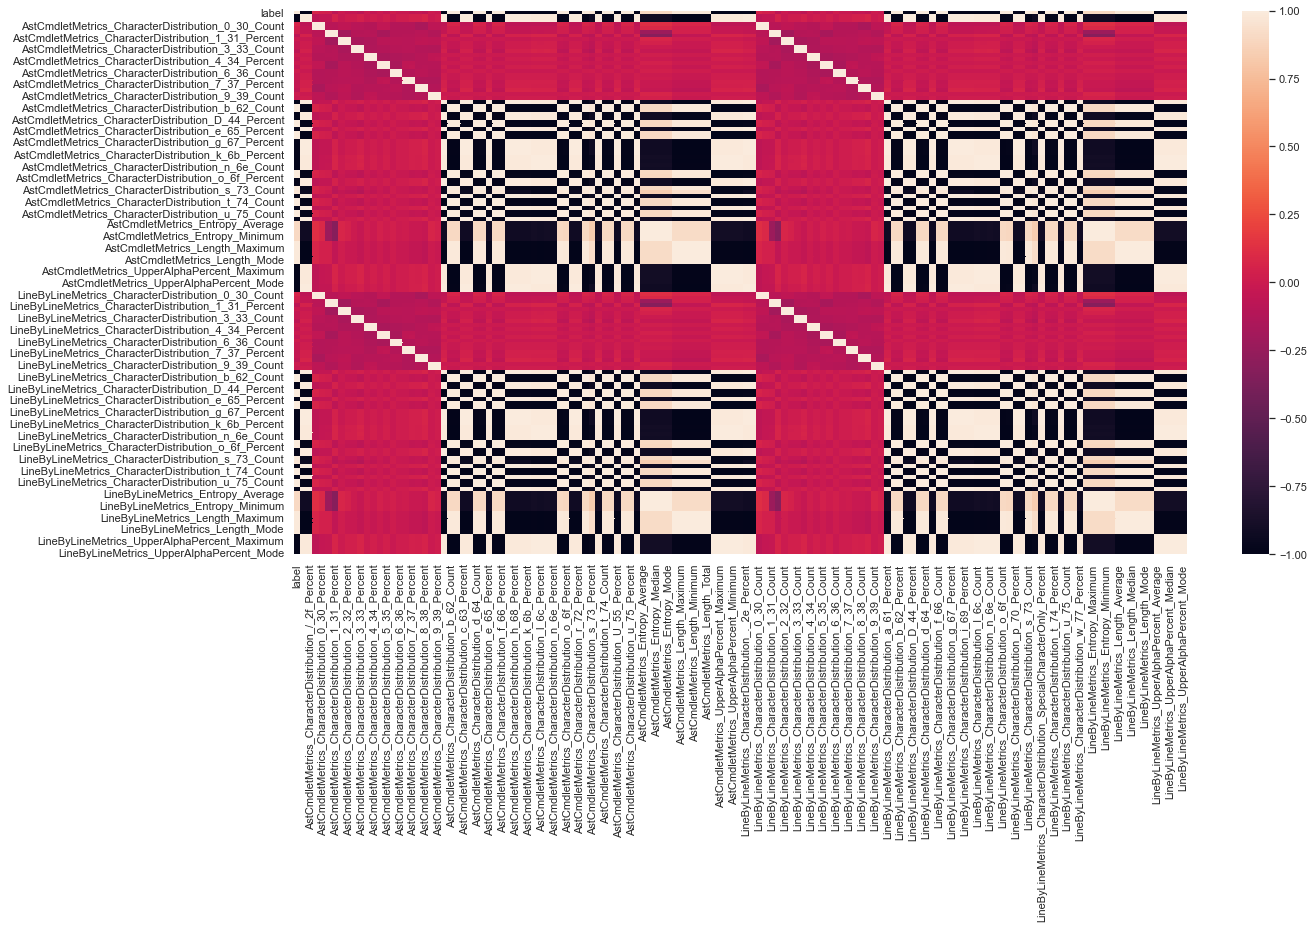

In [307]:
sns.heatmap(correlationMat)

In [309]:
tempDF = final_DF.copy()

## New Pipeline

In [393]:
# train test split
#x = tempDF.loc[:, ['fileName', 'content','label']]
x = tempDF
y = tempDF['label']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.3, stratify=y)

In [394]:
x.head()

,fileName,content,label,AstCmdletMetrics_CharacterDistribution_._2e_Percent,AstCmdletMetrics_CharacterDistribution_/_2f_Percent,AstCmdletMetrics_CharacterDistribution_0_30_Count,AstCmdletMetrics_CharacterDistribution_0_30_Percent,AstCmdletMetrics_CharacterDistribution_1_31_Count,AstCmdletMetrics_CharacterDistribution_1_31_Percent,AstCmdletMetrics_CharacterDistribution_2_32_Count,...,LineByLineMetrics_Length_Maximum,LineByLineMetrics_Length_Median,LineByLineMetrics_Length_Minimum,LineByLineMetrics_Length_Mode,LineByLineMetrics_Length_Total,LineByLineMetrics_UpperAlphaPercent_Average,LineByLineMetrics_UpperAlphaPercent_Maximum,LineByLineMetrics_UpperAlphaPercent_Median,LineByLineMetrics_UpperAlphaPercent_Minimum,LineByLineMetrics_UpperAlphaPercent_Mode
0,c5158,Function Setup-Profile{\r\n \r\n $hasPro...,0,1.960784,11.764706,0,0.0,2,3.921569,0,...,51,51,51,51,51,0.051282,0.051282,0.051282,0.051282,0.051282
1,c866,function Get-FridaysThirteenth {\r\n\tparam (\...,0,2.000000,12.000000,0,0.0,1,2.000000,0,...,50,50,50,50,50,0.051282,0.051282,0.051282,0.051282,0.051282
2,c4534,Set-Alias sudo Invoke-RunAs\r\n\r\nfunction In...,0,1.960784,11.764706,0,0.0,1,1.960784,0,...,51,51,51,51,51,0.051282,0.051282,0.051282,0.051282,0.051282
3,c6323,function Show-AsciiFace{\r\n param(...,0,1.960784,11.764706,0,0.0,1,1.960784,1,...,51,51,51,51,51,0.051282,0.051282,0.051282,0.051282,0.051282
4,c696,"function elevate-process\r\n{\r\n\t$file, [str...",0,2.000000,12.000000,0,0.0,1,2.000000,0,...,50,50,50,50,50,0.051282,0.051282,0.051282,0.051282,0.051282


Next I'll be discussing on multipe transformers(custom and inbuilt) that are going to be used in the pipeline
1. CharacterTransformer : 
* This transformer take the content of the file as string and calculated the 100 dimension vector along with total number of characters
2. CosineSimilarityTransformer : 
* This transformer takes the dataframe as input. It also calculates the average vector of clean and obfucated file as done previously and fit the data. 
* The average vector is used to calculate the cosine similarity between the file charactort vector. 
* In addition to cosine similarity with clean vector, cosine similarity with obfuscated vector is also calculated
3. DropTransformer:
* This is last step were unnessary columns are dropped such that final dataframe only contains relevant columns

In [363]:
from sklearn.base import BaseEstimator, TransformerMixin

In [476]:
class CharacterTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.chars = [c for c in string.printable]
    
    def __characterCount(self, string):
        # charater count
        c = Counter(string)
        # charater vector
        vector = [c.get(char, 0) for char in self.chars]
        # print(vector)
        return pd.Series([vector, sum(vector)])
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X,y=None):
        X_new = X.copy()
        X_new[['characterVector', 'totalCharacter']] = X['content'].apply(self.__characterCount)
        # print(X.head())
        return X_new

class CosineSimilarityTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.AvgClean = None
        self.AvgObfus = None
        self.normClean = None
        self.normObfus = None
    
    def __averageCharacters(self, df):
        total = df.shape[0]
        return np.sum(np.array(df['characterVector'].to_list()), axis = 0)/total
    
    def __cosineSimilarity(self, vector, base):
        if base == 'clean':
            cos_sim = dot(vector, self.AvgClean)/(norm(vector)*self.normClean)
        else:
            cos_sim = dot(vector, self.AvgObfus)/(norm(vector)*self.normObfus)
        return cos_sim
    
    def fit(self, X, y=None):
        # only include clean data from training
        temp = X[X['label'] == 0]
        self.AvgClean = self.__averageCharacters(temp)
        self.normClean = norm(self.AvgClean)
        temp = X[X['label'] == 1]
        self.AvgObfus = self.__averageCharacters(temp)
        self.normObfus = norm(self.AvgObfus)
        return self
    
    def transform(self, X,y=None):
        # self.fit(X)
        X_new = X.copy()
        X_new['cosineSimClean'] = X['characterVector'].apply(lambda x : self.__cosineSimilarity(x, 'clean'))
        X_new['cosineSimObfus'] = X['characterVector'].apply(lambda x : self.__cosineSimilarity(x, 'obfus'))
        # print(X.head())
        return X_new

class DropTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop):
        self.drop = drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X,y=None):
        colsX = list(X.columns)
        new = [col for col in self.drop if col in colsX]
        self.drop = new
        try:
            X.drop(self.drop, axis='columns', inplace=True)
        except Exception as e:
            print(e)
        # print(X.head())
        return X

class CorrTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, threshold=1):
        self.threshold = threshold
        self.corrSet = set()
    
    def fit(self, X, y=None):
        corrMat = X.corr()
        for i in range(0, len(corrMat.columns)):
            for j in range(i):
                if abs(corrMat.iloc[i, j]) > self.threshold:
                    colname = corrMat.columns[i]
                    self.corrSet.add(colname)
        
        for i in range(1, len(corrMat.columns)):
            if int(abs(corrMat.iloc[0, i])) == 1:
                colname = corrMat.columns[i]
                self.corrSet.add(colname)
        # print(self.threshold)
        # print(self.corrSet)
        return self
    
    def transform(self, X,y=None):
        # print(self.threshold)
        # print(self.corrSet)
        try:
            X.drop(self.corrSet, axis='columns', inplace=True)
        except Exception as e:
            print(e)
        return X

In [395]:
dropColumnsList = ['fileName', 'content', 'characterVector', 'label', 'notthere']
pipe2 = Pipeline(steps = [
                            ('characterCount', CharacterTransformer()),
                            ('cosineSimilarity', CosineSimilarityTransformer()),
                            ('dropColumns', DropTransformer(dropColumnsList)),
                            ('classifier' , LogisticRegression())
                            
])

# pipe = Pipeline([('pca', PCA(n_components=20)), ('classifier' , LogisticRegression())])

param_grid = [
                {'classifier' : [LogisticRegression()],
                 'classifier__penalty' : ['l1', 'l2'],
                 'classifier__C' : np.logspace(-4, 4, 20),
                 'classifier__solver' : ['liblinear']},
]

clf = GridSearchCV(pipe2, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

best_clf = clf.fit(xTrain, yTrain)

yPred = best_clf.predict(xTest)

print(classification_report(yTest, yPred))

# pipe2.fit(xTrain, yTrain)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       324
           1       1.00      1.00      1.00       142

    accuracy                           1.00       466
   macro avg       1.00      1.00      1.00       466
weighted avg       1.00      1.00      1.00       466



In [384]:
best_clf.best_estimator_._final_estimator

LogisticRegression(C=0.000774263682681127, solver='liblinear')

I was also surprised by the above result. How often do you get 100% accuracy!!!
On analysing the correlation matrix, it was evident that multiple features had correlation of 1 or -1 with the label. Due to this the accuracy was 100%.

#### These column have correlation of 1 or -1 with label therefore the accuracy is 100%

In [449]:
corrMat = tempDF.corr()
corrCols = []
for i in range(1, len(corrMat.columns)):
    if int(abs(corrMat.iloc[0, i])) == 1:
        colname = corrMat.columns[i]
        corrCols.append(colname)
print(*corrCols, sep='\n')

AstCmdletMetrics_CharacterDistribution_b_62_Count
AstCmdletMetrics_CharacterDistribution_d_64_Count
AstCmdletMetrics_CharacterDistribution_f_66_Count
AstCmdletMetrics_CharacterDistribution_n_6e_Count
AstCmdletMetrics_CharacterDistribution_s_73_Count
AstCmdletMetrics_CharacterDistribution_t_74_Count
AstCmdletMetrics_CharacterDistribution_u_75_Count
LineByLineMetrics_CharacterDistribution_b_62_Count
LineByLineMetrics_CharacterDistribution_d_64_Count
LineByLineMetrics_CharacterDistribution_f_66_Count
LineByLineMetrics_CharacterDistribution_n_6e_Count
LineByLineMetrics_CharacterDistribution_s_73_Count
LineByLineMetrics_CharacterDistribution_t_74_Count
LineByLineMetrics_CharacterDistribution_u_75_Count


## Iteration 3

### Remove features that have correlation of 1 with label

In addition to removing feature that had correlation of 1 with label. To reduce the dimentionality,I also wrote a custom transformer that removes highly correlated features. Of course highly correlated is subjective therefore, the transformer also has a tunable hyperparameter 'threshold' that can be passed in gridSearchCV.

In [396]:
tempDF1 = final_DF.copy()

In [532]:
x = tempDF1
y = tempDF1['label']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, stratify=y)

In [435]:
dropColumnsList = ['fileName', 'content', 'characterVector', 'label', 'notthere']
pipe2 = Pipeline(steps = [
                            ('removeCorrelatedFeature', CorrTransformer()),
                            ('characterCount', CharacterTransformer()),
                            ('cosineSimilarity', CosineSimilarityTransformer()),
                            ('dropColumns', DropTransformer(dropColumnsList)),
                            ('classifier' , LogisticRegression())
                            
])

# pipe = Pipeline([('pca', PCA(n_components=20)), ('classifier' , LogisticRegression())])

param_grid = [
                {'removeCorrelatedFeature__threshold' : [0.8, 0.9, 0.99],
                 'classifier' : [LogisticRegression()],
                 'classifier__penalty' : ['l1', 'l2'],
                 'classifier__C' : np.logspace(-4, 4, 10),
                 'classifier__solver' : ['lbfgs','liblinear']},
]

clf = GridSearchCV(pipe2, param_grid = param_grid, cv = 5, verbose=3, n_jobs=-1)

best_clf = clf.fit(xTrain, yTrain)

yPred = best_clf.predict(xTest)

print(classification_report(yTest, yPred))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00        95

    accuracy                           1.00       311
   macro avg       1.00      1.00      1.00       311
weighted avg       1.00      1.00      1.00       311



In [436]:
best_clf.best_estimator_

Pipeline(steps=[('removeCorrelatedFeature', CorrTransformer(threshold=0.99)),
                ('characterCount', CharacterTransformer()),
                ('cosineSimilarity', CosineSimilarityTransformer()),
                ('dropColumns',
                 DropTransformer(drop=['fileName', 'content', 'characterVector',
                                       'label'])),
                ('classifier',
                 LogisticRegression(C=0.046415888336127774, penalty='l1',
                                    solver='liblinear'))])

Even after removing that we get very good results.

In [455]:
corrMat = tempDF.corr()
corrS = []
for i in range(1, len(corrMat.columns)):
    if abs(corrMat.iloc[0, i]) > 0.99 and int(abs(corrMat.iloc[0, i])) != 1:
        colname = corrMat.columns[i]
        corrS.append((colname, abs(corrMat.iloc[0, i])))
print(*corrS, sep='\n')

('AstCmdletMetrics_CharacterDistribution_b_62_Percent', 0.9999698026779964)
('AstCmdletMetrics_CharacterDistribution_d_64_Percent', 0.9997376251071588)
('AstCmdletMetrics_CharacterDistribution_f_66_Percent', 0.9999698026779964)
('AstCmdletMetrics_CharacterDistribution_l_6c_Count', 0.9999999999999998)
('AstCmdletMetrics_CharacterDistribution_l_6c_Percent', 0.9994305657562772)
('AstCmdletMetrics_CharacterDistribution_n_6e_Percent', 0.9997199618450602)
('AstCmdletMetrics_CharacterDistribution_o_6f_Count', 0.9999999999999998)
('AstCmdletMetrics_CharacterDistribution_o_6f_Percent', 0.9990067331709752)
('AstCmdletMetrics_CharacterDistribution_t_74_Percent', 0.9997376251071588)
('AstCmdletMetrics_CharacterDistribution_u_75_Percent', 0.9999698026779964)
('AstCmdletMetrics_UpperAlphaPercent_Average', 0.9999999999999988)
('AstCmdletMetrics_UpperAlphaPercent_Maximum', 0.9999999999999988)
('AstCmdletMetrics_UpperAlphaPercent_Median', 0.9999999999999988)
('AstCmdletMetrics_UpperAlphaPercent_Minimum

Analysis: There are still highly correlated features with label.

## Iteration 4 with normalization and with/without PCA

In [438]:
from sklearn.preprocessing import StandardScaler

In [533]:
dropColumnsList = ['fileName', 'content', 'characterVector', 'label', 'notthere']
pipe2 = Pipeline(steps = [
                            ('removeCorrelatedFeature', CorrTransformer()),
                            ('characterCount', CharacterTransformer()),
                            ('cosineSimilarity', CosineSimilarityTransformer()),
                            ('dropColumns', DropTransformer(dropColumnsList)),
                            ('standardScaler', StandardScaler()),
                            #('pca', PCA()),
                            ('classifier' , LogisticRegression())
                            
])

param_grid = [
                {'removeCorrelatedFeature__threshold' : [0.9, 0.95],
                 #'pca__n_components' : ['mle', 1, 5],
                 #'pca__svd_solver' : ['auto', 'full'],
                 'classifier' : [LogisticRegression()],
                 'classifier__penalty' : ['l1', 'l2'],
                 'classifier__C' : np.logspace(-4, 4, 5),
                 'classifier__solver' : ['lbfgs','liblinear']},
    
                {'removeCorrelatedFeature__threshold' : [0.9, 0.95],
                 'classifier' : [RandomForestClassifier()],
                 'classifier__n_estimators': [200, 500],
                 'classifier__max_features': ['auto', 'sqrt', 'log2'],
                 'classifier__max_depth' : [4,5,6,7,8],
                 'classifier__criterion' :['gini', 'entropy']},
    
]
# optimising for recall
clf = GridSearchCV(pipe2, param_grid = param_grid, cv = 5, scoring='recall_macro',verbose=5, n_jobs=-1)

best_clf = clf.fit(xTrain, yTrain)

yPred = best_clf.predict(xTest)

print(classification_report(yTest, yPred))
print(confusion_matrix(yTest, yPred))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      0.99      0.99        95

    accuracy                           1.00       311
   macro avg       1.00      0.99      1.00       311
weighted avg       1.00      1.00      1.00       311

[[216   0]
 [  1  94]]


In [536]:
best_clf.best_estimator_

Pipeline(steps=[('removeCorrelatedFeature', CorrTransformer(threshold=0.95)),
                ('characterCount', CharacterTransformer()),
                ('cosineSimilarity', CosineSimilarityTransformer()),
                ('dropColumns',
                 DropTransformer(drop=['fileName', 'content', 'characterVector',
                                       'label'])),
                ('standardScaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

In [537]:
best_clf.best_estimator_._final_estimator.coef_

array([[ 0.00000000e+00,  1.78462164e+00, -1.41301046e-01,
        -9.39852118e-03,  0.00000000e+00, -4.87246021e-02,
         0.00000000e+00,  0.00000000e+00,  4.43605468e-01,
         0.00000000e+00,  9.97177071e+00,  4.37983531e-03,
        -2.11196940e-01,  0.00000000e+00]])

## Error Analysis

In [489]:
yPred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,

In [498]:
pred = pd.Series(yPred)

In [500]:
pred

0      0
1      0
2      0
3      0
4      0
      ..
306    0
307    0
308    1
309    0
310    0
Length: 311, dtype: int64

In [494]:
error = xTest.loc[:, ['fileName', 'content']]

In [510]:
error['label'] = pd.Series(yTest)
error['predicted'] = yPred
error

,fileName,content,label,predicted
739,c1437,function calculateurl ([string]$source)\r\n{\r...,0,0
316,c435,param($Cmdlet) foreach ($paramset in (Get-Comm...,0,0
812,c1874,"\r\nparam(\r\n [switch]$ps, ...",0,0
1016,c1124,"param(\r\n\t[switch]$Help\r\n\t, [string] $Use...",0,0
240,c6079,\r\n\r\n@echo off\r\nCLS\r\nSETLOCAL\r\n\r\nSE...,0,0
...,...,...,...,...
783,c5452,Add-Type -Assembly PresentationFramework\r\nAd...,0,0
443,c2733,param ([String] $ScreenName)\r\n\r\n$client = ...,0,0
1309,o829,""" $(sEt 'ofs' '')"" +([stRinG][reGEX]::MAtchE...",1,1
57,c898,"[reflection.Assembly]::LoadWithPartialName(""sy...",0,0


In [511]:
error.isna().sum()

fileName     0
content      0
label        0
predicted    0
dtype: int64

In [512]:
error[error['label'] != error['predicted']]

,fileName,content,label,predicted
1154,o888,".('Add-'+'Ty'+'pe') @""\r\npublic class Shift {...",1,0


## Conclusion

* The results look good with only one error.
* After removing highly corelated features based on threshold, there were only handful of features left there PCA did not give good results.
* 14 features were used
* Recall_micro was chosen as classification metric as stated above
* Threshold of 0.95 was obtained after tuning. This means all features that had correation greater than 0.95 was removed
* Logistic Regression was the choice of model because of the size of the data and as we were performing binary classification. The hyperparamerters were tunen for classifier too.
* As the results were good I did not generate more obfuscated code.
